In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import textwrap

In [2]:
CSV_PATH = "songs_normalize.csv"

CANDIDATE_FEATURES = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

EPS_VALUES = [0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
MIN_SAMPLES_VALUES = [3, 5, 10, 15]

USE_PCA = True
PCA_COMPONENTS = 5

MIN_NON_NOISE_FRACTION = 0.4  
MIN_CLUSTERS = 2               

In [3]:
print("Loading data...")
df = pd.read_csv(CSV_PATH)

features = [f for f in CANDIDATE_FEATURES if f in df.columns]

if not features:
    raise ValueError(
        f"None of the expected audio feature columns were found. "
        f"Looked for: {CANDIDATE_FEATURES}\n"
        f"Got columns: {list(df.columns)}"
    )

print(f"Using features: {features}")

X = df[features].dropna()
X_index = X.index 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data shape (after dropna): {X_scaled.shape}")

if USE_PCA:
    pca = PCA(n_components=PCA_COMPONENTS, random_state=0)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA reduced shape: {X_pca.shape}")
else:
    X_pca = None

Loading data...
Using features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Data shape (after dropna): (2000, 9)
PCA reduced shape: (2000, 5)


In [4]:

def evaluate_dbscan(X_data, eps, min_samples, label):
    """
    Run DBSCAN on X_data and return a dict of metrics.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_data)

    unique_labels = set(labels)
    clusters = [c for c in unique_labels if c != -1]
    n_clusters = len(clusters)

    n_points = len(labels)
    n_noise = np.sum(labels == -1)
    frac_noise = n_noise / n_points if n_points > 0 else 1.0

    sil = None
    if n_clusters >= 2:
        mask = labels != -1
        if np.sum(mask) > 10:
            try:
                sil = silhouette_score(X_data[mask], labels[mask])
            except Exception:
                sil = None

    return {
        "data_label": label,
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "n_noise": int(n_noise),
        "frac_noise": frac_noise,
        "silhouette": sil
    }

In [5]:
results = []

print("\n=== Running DBSCAN grid search on scaled data ===")
for eps in EPS_VALUES:
    for ms in MIN_SAMPLES_VALUES:
        metrics = evaluate_dbscan(X_scaled, eps, ms, label="scaled")
        results.append(metrics)
        print(f"[scaled] eps={eps:.2f}, min_samples={ms} "
              f"→ clusters={metrics['n_clusters']}, "
              f"noise={metrics['n_noise']} "
              f"({metrics['frac_noise']*100:.1f}%), "
              f"sil={metrics['silhouette']}")

if USE_PCA:
    print("\n=== Running DBSCAN grid search on PCA-reduced data ===")
    for eps in EPS_VALUES:
        for ms in MIN_SAMPLES_VALUES:
            metrics = evaluate_dbscan(X_pca, eps, ms, label="pca")
            results.append(metrics)
            print(f"[pca] eps={eps:.2f}, min_samples={ms} "
                  f"→ clusters={metrics['n_clusters']}, "
                  f"noise={metrics['n_noise']} "
                  f"({metrics['frac_noise']*100:.1f}%), "
                  f"sil={metrics['silhouette']}")

results_df = pd.DataFrame(results)
print("\n=== All DBSCAN configurations (raw table) ===")
print(results_df)


meaningful = results_df[
    (results_df["n_clusters"] >= MIN_CLUSTERS) &
    (1 - results_df["frac_noise"] >= MIN_NON_NOISE_FRACTION)
]

print("\n=== 'Meaningful' configs (enough clusters and not too much noise) ===")
if meaningful.empty:
    print("No configuration produced well-separated clusters with reasonable noise level.")
else:
    print(meaningful.sort_values(by=["silhouette"], ascending=False))


best_sil = meaningful.dropna(subset=["silhouette"])
if not best_sil.empty:
    best_row = best_sil.sort_values(by="silhouette", ascending=False).iloc[0]
    print("\n=== Best configuration by silhouette score ===")
    print(best_row)
else:
    best_row = None
    print("\nNo configuration had a valid silhouette score with enough clusters and points.")



=== Running DBSCAN grid search on scaled data ===
[scaled] eps=0.15, min_samples=3 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.15, min_samples=5 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.15, min_samples=10 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.15, min_samples=15 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.20, min_samples=3 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.20, min_samples=5 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.20, min_samples=10 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.20, min_samples=15 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.30, min_samples=3 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.30, min_samples=5 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.30, min_samples=10 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.30, min_samples=15 → clusters=0, noise=2000 (100.0%), sil=None
[scaled] eps=0.40, 

In [6]:
labels_best = None
X_for_plot = None

if best_row is not None:
    if best_row["data_label"] == "scaled":
        X_best = X_scaled
        X_for_plot = X_scaled
    else:
        X_best = X_pca
        X_for_plot = X_pca

    db_best = DBSCAN(eps=best_row["eps"], min_samples=int(best_row["min_samples"]))
    labels_best = db_best.fit_predict(X_best)

    df_sub = df.loc[X_index].copy()
    df_sub["cluster"] = labels_best

    noise_df = df_sub[df_sub["cluster"] == -1]
    cluster_df = df_sub[df_sub["cluster"] != -1]

    print("\n=== Investigation of Best Configuration ===")
    print(f"Total points clustered: {len(df_sub)}")
    print(f"Noise points: {len(noise_df)} "
          f"({len(noise_df)/len(df_sub)*100:.1f}%)")
    print(f"Clustered points: {len(cluster_df)} "
          f"({len(cluster_df)/len(df_sub)*100:.1f}%)")
    print(f"Number of clusters (excluding noise): "
          f"{df_sub['cluster'].nunique() - (1 if -1 in df_sub['cluster'].unique() else 0)}")

    summary = pd.DataFrame({
        "noise_mean": noise_df[features].mean(),
        "cluster_mean": cluster_df[features].mean()
    })
    summary["difference"] = summary["noise_mean"] - summary["cluster_mean"]
    summary = summary.sort_values("difference", key=lambda s: s.abs(), ascending=False)

    print("\n=== Feature Differences (Noise vs Clustered) ===")
    print(summary)

    name_cols = [c for c in ["track_name", "name"] if c in df_sub.columns]
    artist_cols = [c for c in ["artists", "artist"] if c in df_sub.columns]
    id_cols = (name_cols + artist_cols)[:2] 
    print("\n=== Example 'Noise' Songs (first 10) ===")
    cols_to_show = id_cols + features
    print(noise_df[cols_to_show].head(10))



=== Investigation of Best Configuration ===
Total points clustered: 2000
Noise points: 209 (10.4%)
Clustered points: 1791 (89.5%)
Number of clusters (excluding noise): 3

=== Feature Differences (Noise vs Clustered) ===
                  noise_mean  cluster_mean  difference
tempo             129.218254    119.061139   10.157115
loudness           -6.890847     -5.351581   -1.539266
liveness            0.294742      0.167968    0.126774
instrumentalness    0.124631      0.002459    0.122172
speechiness         0.187273      0.093800    0.093473
valence             0.475520      0.560578   -0.085059
energy              0.649574      0.728627   -0.079053
acousticness        0.186567      0.122232    0.064335
danceability        0.614096      0.673662   -0.059567

=== Example 'Noise' Songs (first 10) ===
              artist  danceability  energy  loudness  speechiness  \
11         Eiffel 65         0.745   0.958    -9.664       0.0287   
12      Bomfunk MC's         0.822   0.922    -5.


Creating scatter plot for best configuration (using PCA 2D projection)...


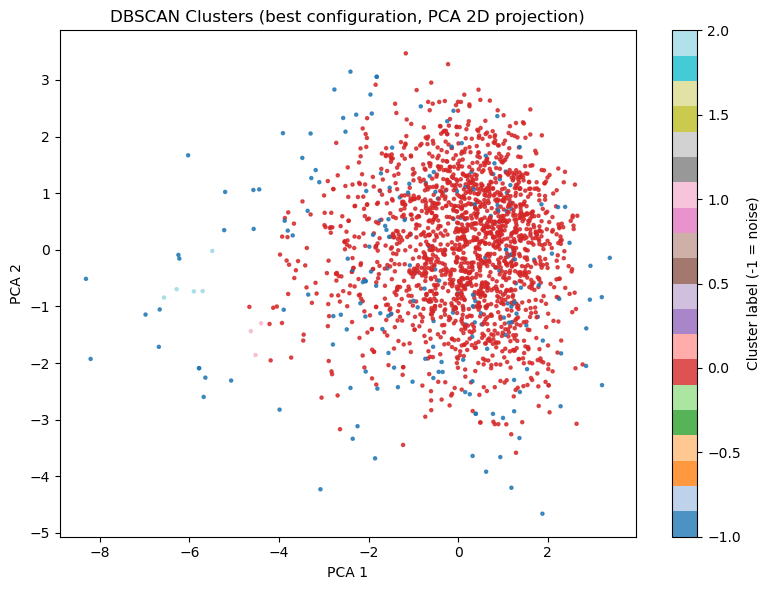


Creating heatmaps for DBSCAN grid search...


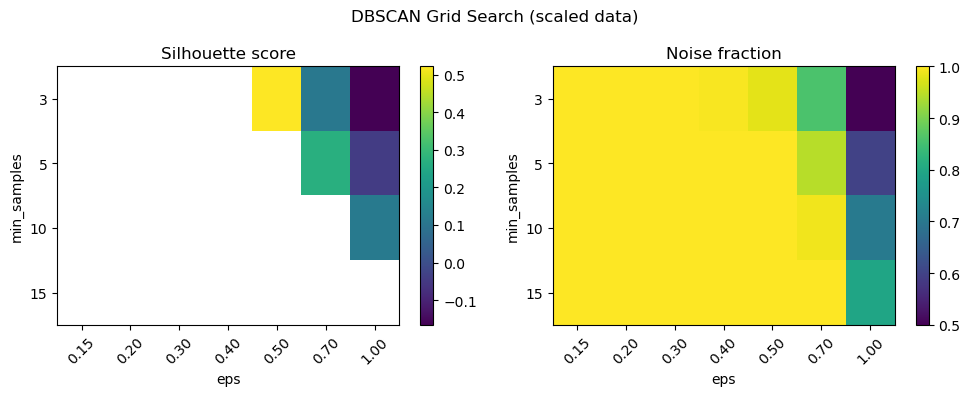

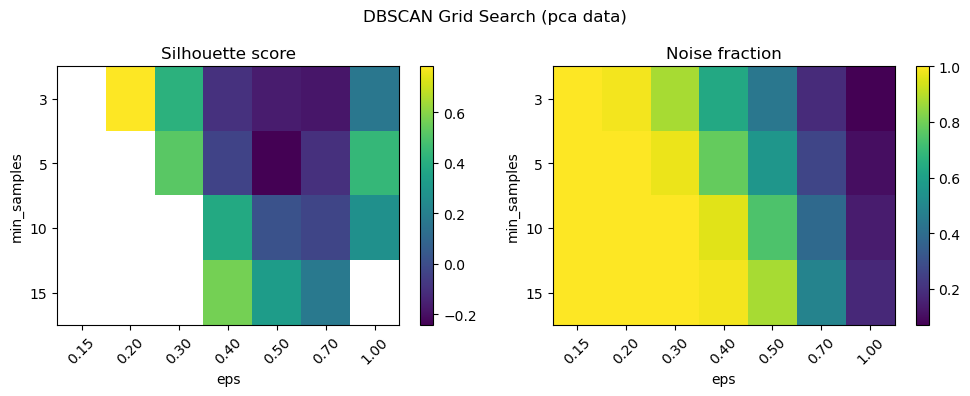


Creating feature difference bar plot (noise vs clustered)...


/tmp/ipykernel_142441/492119868.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary.index, rotation=45, ha="right")


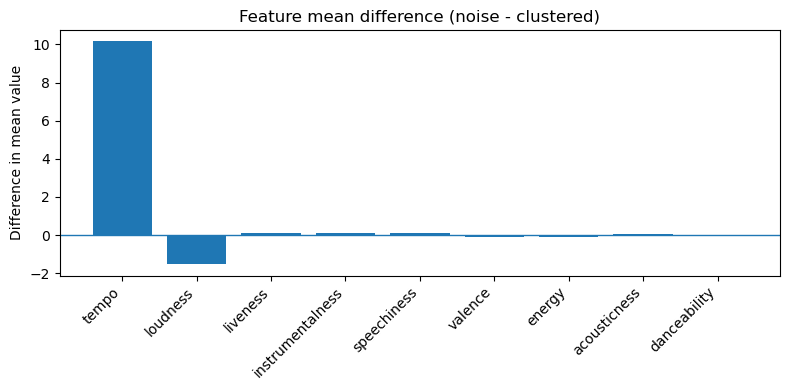


Creating histograms for tempo and instrumentalness...


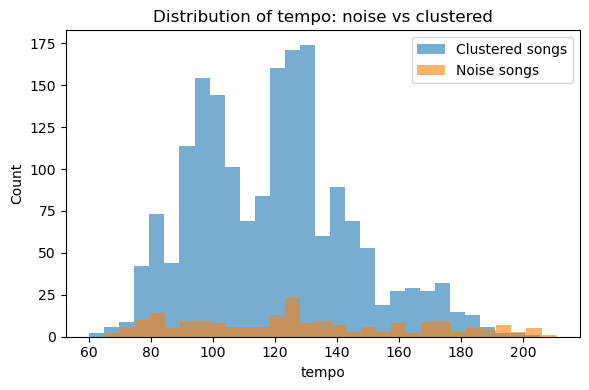

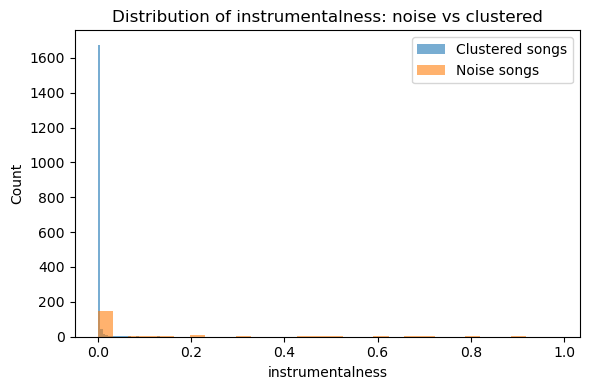


Creating scatter plot for best configuration (PCA 2D projection)...


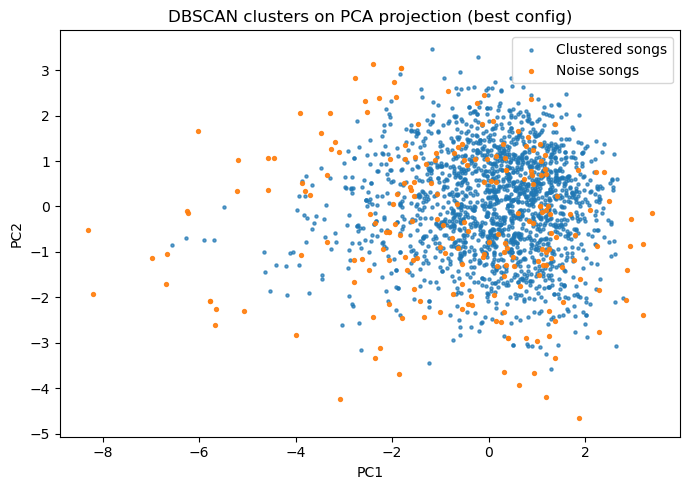


Analysis complete.


In [7]:
if best_row is not None and labels_best is not None:
    print("\nCreating scatter plot for best configuration (using PCA 2D projection)...")

    pca2 = PCA(n_components=2, random_state=0)
    X_2d = pca2.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=labels_best, s=5, cmap="tab20", alpha=0.8
    )
    plt.title("DBSCAN Clusters (best configuration, PCA 2D projection)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(scatter, label="Cluster label (-1 = noise)")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'best' configuration found to visualize.")


# 1) Heatmaps of silhouette and noise fraction over (eps, min_samples)
print("\nCreating heatmaps for DBSCAN grid search...")

for label in ["scaled", "pca"]:
    sub = results_df[results_df["data_label"] == label].copy()
    if sub.empty:
        continue

    sil_pivot = sub.pivot(index="min_samples", columns="eps", values="silhouette")
    noise_pivot = sub.pivot(index="min_samples", columns="eps", values="frac_noise")

    sil_pivot = sil_pivot.sort_index().sort_index(axis=1)
    noise_pivot = noise_pivot.sort_index().sort_index(axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"DBSCAN Grid Search ({label} data)")

    im1 = axes[0].imshow(sil_pivot.values, aspect="auto")
    axes[0].set_title("Silhouette score")
    axes[0].set_xlabel("eps")
    axes[0].set_ylabel("min_samples")
    axes[0].set_xticks(range(len(sil_pivot.columns)))
    axes[0].set_xticklabels([f"{c:.2f}" for c in sil_pivot.columns], rotation=45)
    axes[0].set_yticks(range(len(sil_pivot.index)))
    axes[0].set_yticklabels(sil_pivot.index)
    fig.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(noise_pivot.values, aspect="auto")
    axes[1].set_title("Noise fraction")
    axes[1].set_xlabel("eps")
    axes[1].set_ylabel("min_samples")
    axes[1].set_xticks(range(len(noise_pivot.columns)))
    axes[1].set_xticklabels([f"{c:.2f}" for c in noise_pivot.columns], rotation=45)
    axes[1].set_yticks(range(len(noise_pivot.index)))
    axes[1].set_yticklabels(noise_pivot.index)
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()


# 2) Bar plot: feature differences (noise vs clustered) for best config
if best_row is not None and labels_best is not None:
    print("\nCreating feature difference bar plot (noise vs clustered)...")

    if "summary" not in locals():
        df_sub = df.loc[X_index].copy()
        df_sub["cluster"] = labels_best
        noise_df = df_sub[df_sub["cluster"] == -1]
        cluster_df = df_sub[df_sub["cluster"] != -1]

        summary = pd.DataFrame({
            "noise_mean": noise_df[features].mean(),
            "cluster_mean": cluster_df[features].mean()
        })
        summary["difference"] = summary["noise_mean"] - summary["cluster_mean"]
        summary = summary.sort_values("difference", key=lambda s: s.abs(), ascending=False)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(summary.index, summary["difference"])
    ax.axhline(0, linewidth=1)
    ax.set_title("Feature mean difference (noise - clustered)")
    ax.set_ylabel("Difference in mean value")
    ax.set_xticklabels(summary.index, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 3) Histograms: tempo & instrumentalness for noise vs clustered (best config)
if best_row is not None and labels_best is not None:
    print("\nCreating histograms for tempo and instrumentalness...")

    df_sub = df.loc[X_index].copy()
    df_sub["cluster"] = labels_best

    noise_df = df_sub[df_sub["cluster"] == -1]
    cluster_df = df_sub[df_sub["cluster"] != -1]

    for feat in ["tempo", "instrumentalness"]:
        if feat not in df_sub.columns:
            continue

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(cluster_df[feat], bins=30, alpha=0.6, label="Clustered songs")
        ax.hist(noise_df[feat], bins=30, alpha=0.6, label="Noise songs")
        ax.set_title(f"Distribution of {feat}: noise vs clustered")
        ax.set_xlabel(feat)
        ax.set_ylabel("Count")
        ax.legend()
        plt.tight_layout()
        plt.show()


# 4) PCA 2D scatter: clusters vs noise (best config)
if best_row is not None and labels_best is not None:
    print("\nCreating scatter plot for best configuration (PCA 2D projection)...")

    pca2 = PCA(n_components=2, random_state=0)
    X_2d = pca2.fit_transform(X_scaled)

    df_plot = pd.DataFrame(X_2d, columns=["PC1", "PC2"], index=X_index)
    df_plot["cluster"] = labels_best

    fig, ax = plt.subplots(figsize=(7, 5))
    noise_mask = df_plot["cluster"] == -1
    ax.scatter(df_plot.loc[~noise_mask, "PC1"],
               df_plot.loc[~noise_mask, "PC2"],
               s=5, alpha=0.7, label="Clustered songs")
    ax.scatter(df_plot.loc[noise_mask, "PC1"],
               df_plot.loc[noise_mask, "PC2"],
               s=8, alpha=0.9, label="Noise songs")

    ax.set_title("DBSCAN clusters on PCA projection (best config)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()
    plt.tight_layout()
    plt.show()

print("\nAnalysis complete.")
